# MLP with JAX

In [1]:
import jax
from jax import random
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

### Using Random Number Generator in Numpy and JAX

In [2]:
np.random.seed(927)
# Different values
print(np.random.normal());print(np.random.normal())

-0.9655518973066672
0.36887883936257826


In [3]:
test_key = random.PRNGKey(205)
# Same values
print(random.normal(test_key));print(random.normal(test_key))

-1.1837974
-1.1837974


In [4]:
# To generate independent samples
key1, key2 = random.split(test_key)
print(random.normal(key1));print(random.normal(key2))

0.7935604
-0.03299528


For more details, consider reading [_Pseudo Random Numbers in JAX_](https://jax.readthedocs.io/en/latest/jax-101/05-random-numbers.html).

## Creating a Regression Dataset

In [5]:
key = random.PRNGKey(3985)
data_rng, param_rng = random.split(key, 2)

In [6]:
X = random.normal(data_rng, [128, 1])
Y = 3.9 * X ** 2.0 + 8.5 * X + 3.09

BS = 32
batchify = lambda z: z.split([*range(BS, X.shape[0], BS)], 0) 
XBS, YBS = batchify(X), batchify(Y)

In [7]:
# Initialize a neural network, i.e., list of params.
def init_params(rng, layer_width):
    keys = random.split(rng, len(layer_width))
    dims = zip(layer_width[:-1], layer_width[1:], keys)
    return [dense_layer(n_in, n_out, key) for n_in, n_out, key in dims]

def dense_layer(n_in, n_out, key):
    W = random.normal(key, [n_out, n_in]) * jnp.sqrt(2.0 / n_in)
    b = jnp.zeros([n_out, ])
    return W, b

def forward(params, x):
    *hidden, (W_out, b_out) = params
    for W, b in hidden:
        x = jax.nn.relu(W @ x + b)
    pred = W_out @ x + b_out
    return pred

In [8]:
# Vectorize forward function
batch_forward = jax.vmap(forward, in_axes=[None, 0])

In [9]:
test_params = init_params(random.PRNGKey(309), [1, 128, 1])
single = forward(test_params, jnp.ones([1]))           # Expected ( 1,  )
batch = batch_forward(test_params, jnp.ones([39, 1]))  # Expected (39, 1)
single.shape, batch.shape

((1,), (39, 1))

In [10]:
# MSE loss function
def loss_fn(params, x, y):
    pred = batch_forward(params, x)
    loss = jnp.mean((y - pred) ** 2.0)
    return loss

In [11]:
# params_tree is a list of tuples, each containing 2 jnp arrays.
params_tree = init_params(random.PRNGKey(929), [1, 128])

# shape_tree is a list of tuples, each containing 2 tuples,
# which are mappings from an array to its shape.
shape_tree = jax.tree_map(lambda leaf: leaf.shape, params_tree)
shape_tree

[((128, 1), (128,))]

In [12]:
# Nested data doesn't need to be the same type.
a_tree = [(2021, 2021), ('Kim ', 'Choi ')]
b_tree = [(-32, -22), ('Taeyeon', 'Yena')]

# Maps elements from a_tree and b_tree to added / concatenated elements
jax.tree_multimap(lambda a, b: a + b, a_tree, b_tree)

[(1989, 1999), ('Kim Taeyeon', 'Choi Yena')]

In [13]:
f = lambda x: x ** 2 + x + 1
dfdx = jax.grad(f)       # First derivative
d2fdx2 = jax.grad(dfdx)  # Second derivative
d2fdx2(1.0), dfdx(1.0)   # Expected 2, 3

(DeviceArray(2., dtype=float32), DeviceArray(3., dtype=float32))

In [14]:
test2_params = init_params(random.PRNGKey(805), [1, 128])
test2_x, test2_y = jnp.zeros([39, 1]), jnp.ones([39, 1])

# Create a derivative function and call the function to calculate derivatives
grad_fn = jax.grad(loss_fn)
grads = grad_fn(test2_params, test2_x, test2_y)

# One-liner
grads2 = jax.grad(loss_fn)(test2_params, test2_x, test2_y)

In [15]:
test2_loss, grads3 = jax.value_and_grad(loss_fn)(test2_params, test2_x, test2_y)
test2_loss

DeviceArray(1., dtype=float32)

In [16]:
get_shape = lambda leaf: leaf.shape 
params_shape = jax.tree_map(get_shape, test2_params)
grads_shape = jax.tree_map(get_shape, grads)
print(params_shape, grads_shape, sep='\n')

[((128, 1), (128,))]
[((128, 1), (128,))]


In [17]:
@jax.jit
def optimizer(params, xbs, ybs):
    epoch_loss = []

    for xb, yb in zip(xbs, ybs):
        loss, grads = jax.value_and_grad(loss_fn)(params, xb, yb)
        params = jax.tree_multimap(lambda p, g: p - LR * g, params, grads)
        epoch_loss.append(loss)

    avg_loss = jnp.mean(jnp.asarray(epoch_loss))

    return params, avg_loss

In [18]:
LR = 3e-4
num_epochs = 25
layer_width = [1, 128, 128, 1]

In [19]:
warmup_params = init_params(param_rng, layer_width)
warmup_loss, warmup_params = optimizer(warmup_params, XBS, YBS)

<ipython-input-20-7f2f7e683ce4>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


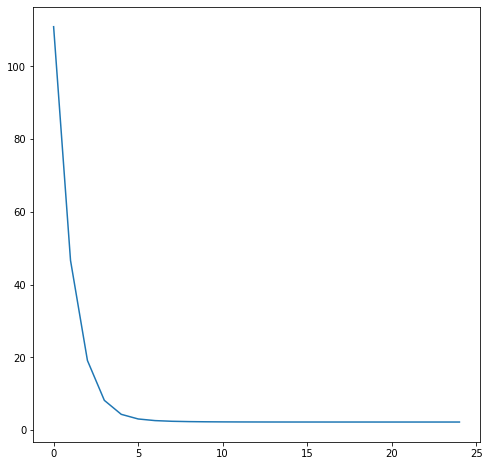

In [20]:
params = init_params(param_rng, layer_width)
loss_hist = []

for epoch in range(num_epochs):
    params, avg_loss = optimizer(params, XBS, YBS)
    loss_hist.append(avg_loss)

fig, ax = plt.subplots(1, 1, figsize=[8, 8])
ax.plot(loss_hist)
fig.show()